In [2]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections

pd.set_option("display.max_column", 999)
print(os.listdir("./"))

['.DS_Store', 'requirements.txt', 'submission.csv', 'README.md', '.gitignore', '2023-winner.ipynb', 'pub-march-machine-learning-mania-2024.ipynb', 'venv', 'march-machine-learning-mania-2024', '.git']


# Load the data!

In [3]:
DATA_PATH = './march-machine-learning-mania-2024/'

tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneyDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv"),
], ignore_index=True)


In [4]:
tourney_results.shape

(2276, 34)

In [5]:
seeds.shape

(4234, 3)

In [6]:
regular_results.shape

(196362, 34)

In [7]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [8]:
regular_results.select_dtypes(include=[np.number]).groupby('Season').mean()

,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003,74.808709,1285.591854,75.795061,1281.750867,63.756932,0.061308,26.299393,55.367851,6.695624,17.377166,16.500650,23.250217,11.580589,25.143847,15.278380,14.211872,7.622184,3.756282,17.880633,22.869584,56.866118,5.824090,18.720971,12.193674,18.055243,11.913345,21.115901,11.877816,15.602903,6.507582,2.768198,20.413128
2004,75.335156,1285.931306,74.971122,1280.900678,62.990155,0.071319,25.928681,55.069350,6.708160,17.570335,16.405601,23.286371,11.608182,25.049880,15.137169,14.049880,7.742070,3.639029,17.798075,22.569241,56.301247,5.826515,18.825202,12.025159,18.057755,11.844235,21.224021,11.870269,15.654999,6.493984,2.741413,20.322468
2005,75.042567,1286.067166,74.693690,1282.088770,62.635294,0.066524,25.975187,54.949305,6.769840,17.678503,15.973476,22.787594,11.565775,24.964920,15.184385,13.907380,7.699251,3.730053,17.403850,22.427594,56.047914,5.904385,18.922139,11.875722,17.767059,11.733690,21.038717,11.771551,15.490481,6.509733,2.806203,19.884492
2006,74.712634,1283.769182,74.587555,1285.425478,62.666597,0.073996,25.920538,54.881228,6.845281,17.821526,15.901198,22.458272,11.591760,24.641581,15.141896,13.893000,7.616985,3.708430,17.253731,22.456801,55.836872,5.945133,18.882279,11.807862,17.589027,11.762035,20.874711,11.833929,15.521127,6.368089,2.836872,19.679210
2007,71.676780,1286.476700,74.829467,1283.896887,62.761650,0.067618,25.896887,54.196907,7.043228,18.138608,15.992465,22.698989,11.222487,24.756098,15.043030,13.909974,7.179853,3.735277,17.443783,22.419790,55.712274,6.059092,19.453500,11.862978,17.645251,11.534404,20.671227,11.667460,15.218917,6.225858,2.760658,19.985524
2008,68.392020,1288.741817,74.962425,1281.907418,62.755375,0.072439,25.932597,54.543289,7.162309,18.386791,15.934922,22.575828,11.133256,25.101491,14.921557,13.720705,7.300213,3.777455,17.450126,22.392408,55.829556,6.165408,19.622119,11.805152,17.567306,11.340306,21.026148,11.578346,15.173155,6.171025,2.836529,19.803021
2009,70.963612,1287.680511,74.033721,1281.312250,61.980377,0.071633,25.724138,54.550200,6.749095,17.743189,15.836350,22.485616,11.178129,25.155839,14.568108,13.223852,7.161174,3.723757,17.297390,22.168223,55.771004,5.759954,18.787579,11.883978,17.740331,11.440846,21.195847,11.328062,14.696895,6.093161,2.777481,19.574776
2010,70.530000,2264.506505,72.629515,2261.125437,59.580971,0.059029,25.443786,56.196893,6.206408,16.806019,15.535534,22.085049,12.321942,26.068932,14.569903,14.909126,8.143204,3.848058,16.811359,21.342718,56.707476,5.180291,17.585049,11.715243,17.524272,12.310680,21.963689,11.016214,16.650097,6.826893,2.861456,19.120388
2011,70.635140,2267.819071,72.557115,2269.176573,59.386641,0.064860,25.368345,56.209197,6.268538,17.049468,15.551888,22.023330,12.257502,26.172217,14.611036,14.643078,8.052953,3.772120,16.798742,21.252081,56.487028,5.240368,17.687318,11.642110,17.396612,12.049177,22.039497,11.027009,16.483543,6.702420,2.914811,19.163311


In [9]:
tourney_results.select_dtypes(include=[np.number]).groupby('Season').mean()

,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003,139.156250,1283.343750,76.562500,1288.765625,65.546875,0.093750,27.703125,57.906250,6.640625,16.281250,14.515625,20.218750,11.781250,25.546875,14.765625,12.875000,7.015625,3.890625,17.453125,23.375000,58.906250,6.515625,19.968750,12.281250,17.796875,12.421875,21.171875,12.031250,13.828125,6.062500,3.281250,18.875000
2004,139.156250,1286.515625,75.500000,1300.640625,64.265625,0.046875,25.890625,54.531250,6.906250,17.500000,16.812500,23.296875,11.125000,25.875000,14.859375,12.546875,6.921875,3.625000,16.625000,23.140625,58.468750,6.203125,20.468750,11.781250,16.750000,11.734375,20.593750,12.296875,12.734375,6.015625,2.031250,19.843750
2005,139.156250,1306.031250,75.562500,1299.562500,65.375000,0.109375,26.281250,54.609375,6.953125,18.015625,16.046875,22.203125,10.609375,25.203125,15.093750,13.078125,7.031250,3.484375,17.000000,23.531250,58.546875,6.328125,19.734375,11.984375,17.234375,12.359375,20.984375,12.265625,13.687500,6.781250,2.343750,19.468750
2006,139.156250,1282.250000,73.203125,1291.500000,63.171875,0.109375,24.984375,54.093750,6.609375,18.015625,16.625000,22.640625,11.109375,24.718750,14.125000,11.906250,6.718750,4.250000,15.562500,22.984375,57.234375,6.171875,19.890625,11.031250,15.625000,11.859375,21.375000,12.187500,13.375000,6.171875,3.171875,19.406250
2007,139.156250,1320.593750,75.703125,1299.421875,63.578125,0.093750,25.515625,54.250000,7.421875,18.406250,17.250000,23.531250,11.531250,25.500000,13.921875,12.265625,6.156250,4.015625,16.796875,22.937500,57.390625,6.046875,19.984375,11.656250,16.875000,11.359375,20.406250,11.500000,12.468750,5.906250,2.843750,20.328125
2008,139.156250,1329.781250,77.218750,1292.046875,63.281250,0.093750,27.500000,55.453125,6.937500,17.375000,15.281250,21.265625,11.312500,26.546875,15.218750,12.718750,6.515625,4.062500,17.468750,22.375000,57.390625,6.250000,20.609375,12.281250,18.171875,11.578125,20.031250,10.890625,12.593750,6.171875,2.890625,19.093750
2009,139.156250,1300.187500,77.250000,1284.843750,64.343750,0.046875,27.062500,57.000000,6.453125,17.265625,16.671875,23.000000,11.812500,26.531250,15.546875,12.250000,6.796875,3.687500,16.453125,23.296875,59.328125,5.968750,20.250000,11.781250,16.953125,11.734375,21.109375,11.703125,12.593750,5.953125,3.234375,19.593750
2010,140.165354,2277.984252,73.574803,2297.748031,60.015748,0.086614,26.007874,57.157480,6.236220,17.047244,15.322835,21.370079,12.496063,26.968504,15.283465,13.307087,7.637795,4.346457,15.511811,21.952756,58.913386,5.472441,18.881890,10.637795,15.763780,12.307087,21.779528,11.188976,14.307087,6.771654,3.078740,18.488189
2011,140.038462,2251.992308,73.523077,2266.100000,60.184615,0.053846,26.184615,56.630769,6.284615,16.592308,14.869231,20.238462,12.000000,26.338462,15.061538,12.784615,7.353846,4.023077,15.076923,22.015385,57.715385,5.730769,19.061538,10.423077,14.861538,11.600000,21.438462,11.369231,14.107692,6.315385,2.715385,18.053846


In [10]:
seeds.tail()

,Season,Seed,TeamID
4229,2024,Z12b,3435
4230,2024,Z13,3267
4231,2024,Z14,3238
4232,2024,Z15,3263
4233,2024,Z16,3394


In [11]:
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19


In [12]:
all(regular_results.columns == tourney_results.columns)

True

# Data preparation!

In [13]:
tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneyDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv"),
], ignore_index=True)

"""
This function takes in a dataframe and performs the following operations:
- Concatenates the dataframe with a copy of itself with the winning and losing teams swapped
- Changes the location of the game to a numerical value (0 for neutral, 1 for home, -1 for away)
- Adds a point differential column
- Returns the new dataframe
"""
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [14]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [15]:
regular_data.shape

(392724, 35)

In [16]:
tourney_data.shape

(4552, 35)

In [17]:
regular_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,10,1104,68,1328,62,0,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,0,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,0,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,0,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,0,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,6


In [18]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,2


# Feature engineering!

In [19]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

In [20]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [21]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.head() # Contains average regular season statistics for each team, separated by season (VERY smart and useful)

/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_33302/1988842530.py:1: FutureWarning: The provided callable <function mean at 0x108b677e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()


,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_Blk,PointDiff
,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [22]:
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [23]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [24]:
season_statistics_T1.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [25]:
season_statistics_T2.head()

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [26]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,2


In [27]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74


In [28]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [29]:
"""
This dataframe now contains all tournament games and outcomes, but with each team's average regular season stats as well. 
"""
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000


In [30]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [31]:
"""
Now, we have the win ratio of each team in the last 14 days of the regular season as a feature in the tournament data.
"""
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')
tourney_data.tail() # checking we have the 2024 stats in the table

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d
4547,2024,147,3425,73,3163,80,26.516129,62.290323,7.548387,21.225806,10.451613,14.806452,11.806452,7.935484,16.129032,22.548387,58.129032,5.451613,17.774194,7.612903,13.354839,14.548387,6.322581,2.677419,12.516129,30.545455,61.636364,7.090909,19.787879,8.121212,19.303030,12.363636,9.818182,14.363636,21.090909,58.212121,6.121212,21.575758,7.484848,11.757576,15.969697,5.212121,2.181818,22.909091,1.000000,1.0
4548,2024,147,3261,87,3234,94,31.212121,66.818182,4.242424,13.212121,14.969697,16.545455,15.212121,10.787879,16.090909,22.818182,62.121212,6.272727,21.181818,8.787879,10.818182,18.939394,8.000000,3.818182,24.151515,33.121212,65.818182,11.303030,29.606061,9.121212,21.878788,13.424242,7.545455,14.696970,26.454545,65.969697,7.848485,25.272727,8.818182,14.242424,14.424242,7.060606,2.848485,20.939394,0.666667,1.0
4549,2024,151,3163,69,3234,71,30.545455,61.636364,7.090909,19.787879,8.121212,19.303030,12.363636,9.818182,14.363636,21.090909,58.212121,6.121212,21.575758,7.484848,11.757576,15.969697,5.212121,2.181818,22.909091,33.121212,65.818182,11.303030,29.606061,9.121212,21.878788,13.424242,7.545455,14.696970,26.454545,65.969697,7.848485,25.272727,8.818182,14.242424,14.424242,7.060606,2.848485,20.939394,1.000000,1.0
4550,2024,151,3301,59,3376,78,27.000000,62.909091,6.030303,18.636364,9.393939,13.606061,12.333333,6.484848,12.575758,22.969697,64.787879,6.454545,22.121212,8.696970,10.848485,12.696970,6.454545,3.575758,13.818182,33.218750,66.812500,6.468750,16.312500,12.406250,18.875000,13.156250,8.750000,14.312500,20.687500,64.656250,5.343750,20.031250,9.250000,10.062500,14.812500,6.625000,3.125000,29.750000,0.666667,1.0
4551,2024,153,3234,75,3376,87,33.121212,65.818182,11.303030,29.606061,9.121212,21.878788,13.424242,7.545455,14.696970,26.454545,65.969697,7.848485,25.272727,8.818182,14.242424,14.424242,7.060606,2.848485,20.939394,33.218750,66.812500,6.468750,16.312500,12.406250,18.875000,13.156250,8.750000,14.312500,20.687500,64.656250,5.343750,20.031250,9.250000,10.062500,14.812500,6.625000,3.125000,29.750000,1.000000,1.0


In [32]:
# Regular season - adding column for whether or not team 1 won
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)


march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)


regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(20268, 5)

In [33]:
regular_season_effects.head()
# Regular season dataframe. Contains point differential and boolean for whether or not team 1 won

,Season,T1_TeamID,T2_TeamID,PointDiff,win
0,2003,1104,1328,6,1
1,2003,1272,1393,7,1
2,2003,1323,1237,44,1
3,2003,1242,1221,24,1
4,2003,1390,1462,1,1


In [34]:
"""
This function is particularly interesting. It uses the parameters of a fitted generalized linear model as a measure of team quality, 
and works as follows:

1. Defines the predictive function (formula). In this case, we are attempting to predict the win column based EXCLUSIVELY on the team IDs
2. Fits a glm based on this formula to regular_season_effects (see previous code cell), specific to the season parameter
3. Extracts the parameters of the glm and stores them in the quality dataframe. These parameters are used as a measure of team quality
"""
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    #quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [35]:
"""
This is a test of the above function. As a sanity check, I also added the team names to the output dataframe.

I'm not entirely sure if it's working as expected (see below)

It could be working since the team ID numbers are different (and not indicative of team skill at all), and the glm is trying to reconcile for that.

Generally I need to figure out why/how this is even working and useful in the first place.
"""
q = team_quality(2023)

mteams = pd.read_csv(DATA_PATH + "MTeams.csv")
wteams = pd.read_csv(DATA_PATH + "WTeams.csv")

q = pd.merge(q, mteams, on='TeamID', how='left').drop(['FirstD1Season', 'LastD1Season'], axis=1)
q = pd.merge(q, wteams, on='TeamID', how='left', suffixes=('', '_y'))
q['TeamName'] = q['TeamName'].combine_first(q['TeamName_y'])
q = q.drop(['TeamName_y'], axis=1)

print(q['TeamName'].isna().sum())
print(q[q['TeamName'] == 'F Dickinson']) # Kenpom 265
print(q[q['TeamName'] == 'Alabama']) # Kenpom 11
print(q[q['TeamName'] == 'Arizona']) # Kenpom 4

/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


0
    TeamID       quality  Season     TeamName
13    1192 -2.875661e+15    2023  F Dickinson
    TeamID       quality  Season TeamName
0     1104  6.447588e+14    2023  Alabama
67    3104  2.020024e+15    2023  Alabama
    TeamID       quality  Season TeamName
1     1112  8.171813e+14    2023  Arizona
68    3112  4.463955e+15    2023  Arizona


In [36]:
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         #team_quality(2020),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023),
                         team_quality(2024)
                         ]).reset_index(drop=True)

/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/stats

In [37]:
glm_quality.head(20)

,TeamID,quality,Season
0,1115,-1.390621e+15,2010
1,1124,3.410081e+15,2010
2,1139,2.919184e+15,2010
3,1140,4.150375e+15,2010
4,1143,2.701393e+15,2010
5,1155,3.455108e+15,2010
6,1165,1.164801e+15,2010
7,1181,4.201799e+15,2010
8,1190,-1.273809e+16,2010
9,1196,1.714340e+15,2010


In [38]:
glm_quality.tail()

,TeamID,quality,Season
1810,3435,8.645686e+14,2024
1811,3439,1.916288e+15,2024
1812,3452,1.153401e+15,2024
1813,3453,-1.248785e+15,2024
1814,3465,3.319368e+15,2024


In [39]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

In [40]:
glm_quality_T2.head()

,T2_TeamID,T2_quality,Season
0,1115,-1.390621e+15,2010
1,1124,3.410081e+15,2010
2,1139,2.919184e+15,2010
3,1140,4.150375e+15,2010
4,1143,2.701393e+15,2010


In [41]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [42]:
tourney_data.head()
# Now tourney_data contains quality ratings for each team as well (for 2010 on, should investigate why that is)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333,NaN,NaN
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000,NaN,NaN
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000,NaN,NaN
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000,NaN,NaN
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000,NaN,NaN


In [43]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [44]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3])) # Isolating only the numerical value of the seed
seeds.tail()

,Season,Seed,TeamID,seed
4229,2024,Z12b,3435,12
4230,2024,Z13,3267,13
4231,2024,Z14,3238,14
4232,2024,Z15,3263,15
4233,2024,Z16,3394,16


In [45]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [46]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [47]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

In [48]:
tourney_data.head()
# Added numerical valued tournament seeds

# To clarify: we are training exclusively on TOURNAMENT GAMES (since we are using tournament seeding as a feature)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333,NaN,NaN,16,16,0
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000,NaN,NaN,1,16,-15
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000,NaN,NaN,10,7,3
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000,NaN,NaN,11,6,5
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000,NaN,NaN,8,9,-1


# Time to build some models!

In [49]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    4552.000000
mean        0.000000
std        17.479045
min       -89.000000
25%       -11.000000
50%         0.000000
75%        11.000000
max        89.000000
dtype: float64

In [50]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

len(features)

45

In [51]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [52]:
# Defining a custom objective function for model
# Uses a cauchy distribution (instead of normal), supposedly less sensitive to outliers
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1) # Scaling residuals for gradient - more robust to outliers, determines step direction
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2 # Hessian - determines step size
    return grad, hess

In [53]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] = 'mae' # NOTE: might not want to use mae depending on current year's eval metric
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['verbose'] = 0

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'verbose': 0}


In [ ]:
xgb_cv = []
repeat_cv = 3 # Original version of this submission recommends 10, 3 seems to be best (4th place 2024 used 3)

# Performs 3 rounds of 5-fold cross validation (with custom objective function defined above)
for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj, # this is where he sets his custom objective function (defined previously)
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:13.40894+0.05953	test-mae:13.41326+0.23926


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:49:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.47561+0.03419	test-mae:9.71957+0.16967
[100]	train-mae:9.10318+0.04051	test-mae:9.57136+0.16183
[150]	train-mae:8.87379+0.04604	test-mae:9.55217+0.15813
[200]	train-mae:8.68144+0.04587	test-mae:9.53471+0.16316
[250]	train-mae:8.50108+0.04951	test-mae:9.53622+0.16562
[258]	train-mae:8.47179+0.04902	test-mae:9.53585+0.16528
Fold repeater 1
[0]	train-mae:13.40732+0.07736	test-mae:13.41009+0.30047


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:49:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.46171+0.05298	test-mae:9.71711+0.19333
[100]	train-mae:9.09361+0.05544	test-mae:9.57354+0.22675
[150]	train-mae:8.86322+0.05506	test-mae:9.55837+0.24505
[200]	train-mae:8.67237+0.05588	test-mae:9.55844+0.25693
[206]	train-mae:8.64869+0.05523	test-mae:9.55942+0.25487
Fold repeater 2
[0]	train-mae:13.41196+0.05341	test-mae:13.41909+0.23383


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:49:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.46849+0.04401	test-mae:9.71635+0.17367
[100]	train-mae:9.10012+0.05716	test-mae:9.55900+0.21099
[150]	train-mae:8.87419+0.05710	test-mae:9.53463+0.21795
[196]	train-mae:8.69320+0.06683	test-mae:9.52559+0.21730
Fold repeater 3
[0]	train-mae:13.41083+0.09201	test-mae:13.42078+0.39269


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:49:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:49:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.46711+0.05429	test-mae:9.72337+0.17959
[100]	train-mae:9.09568+0.05224	test-mae:9.57013+0.19446
[135]	train-mae:8.92937+0.05131	test-mae:9.56936+0.19952
Fold repeater 4
[0]	train-mae:13.41215+0.06794	test-mae:13.41713+0.27614


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:49:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.46033+0.01571	test-mae:9.73183+0.09334
[100]	train-mae:9.09379+0.02134	test-mae:9.58605+0.06361
[150]	train-mae:8.86358+0.03045	test-mae:9.55582+0.07436
[200]	train-mae:8.67165+0.03183	test-mae:9.54994+0.08917
[240]	train-mae:8.52688+0.03531	test-mae:9.54770+0.08986
Fold repeater 5
[0]	train-mae:13.41335+0.12050	test-mae:13.41667+0.49771


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:49:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.47541+0.04260	test-mae:9.71744+0.17766
[100]	train-mae:9.11004+0.04034	test-mae:9.57558+0.18761
[150]	train-mae:8.88059+0.04000	test-mae:9.55573+0.20812
[200]	train-mae:8.67770+0.03615	test-mae:9.54951+0.21071
[250]	train-mae:8.50420+0.03834	test-mae:9.54478+0.22061
[273]	train-mae:8.42816+0.03994	test-mae:9.55067+0.22018
Fold repeater 6
[0]	train-mae:13.40901+0.06752	test-mae:13.41687+0.29683


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:49:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.46958+0.02689	test-mae:9.71891+0.12268
[100]	train-mae:9.09720+0.03281	test-mae:9.57111+0.12995
[150]	train-mae:8.86736+0.04047	test-mae:9.55286+0.13439
[199]	train-mae:8.67520+0.04044	test-mae:9.55833+0.13667
Fold repeater 7
[0]	train-mae:13.41372+0.07023	test-mae:13.41729+0.29141


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:49:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.46753+0.06720	test-mae:9.74721+0.27126
[100]	train-mae:9.09446+0.06743	test-mae:9.60131+0.26394
[150]	train-mae:8.86867+0.06884	test-mae:9.59318+0.25938
[185]	train-mae:8.73260+0.06128	test-mae:9.59366+0.25719
Fold repeater 8
[0]	train-mae:13.41142+0.09825	test-mae:13.41476+0.40719


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:49:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.47124+0.08387	test-mae:9.72543+0.36301
[100]	train-mae:9.10244+0.09032	test-mae:9.59763+0.35999
[150]	train-mae:8.87198+0.08805	test-mae:9.58273+0.35832
[161]	train-mae:8.82661+0.08807	test-mae:9.58456+0.35261
Fold repeater 9
[0]	train-mae:13.41155+0.06546	test-mae:13.41460+0.24701


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:49:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.47001+0.05226	test-mae:9.70797+0.19788
[100]	train-mae:9.09933+0.04532	test-mae:9.56887+0.19579
[150]	train-mae:8.87771+0.04603	test-mae:9.54625+0.19277
[180]	train-mae:8.75656+0.04605	test-mae:9.54379+0.19591


In [55]:
# This part is important - connects the previous training step to the next one 

# Stores the number of iterations it took to achieve the best mae for each of the 5-fold cross validations
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]

# Stores the best mae for each of the 5-fold cross validations
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]

iteration_counts, val_mae

([np.int64(234),
  np.int64(182),
  np.int64(172),
  np.int64(110),
  np.int64(216),
  np.int64(249),
  np.int64(174),
  np.int64(160),
  np.int64(137),
  np.int64(156)],
 [np.float64(9.527204371515476),
  np.float64(9.549481652441912),
  np.float64(9.522869335501602),
  np.float64(9.56323574036708),
  np.float64(9.545767251247348),
  np.float64(9.543170744556278),
  np.float64(9.547696788578827),
  np.float64(9.58741342603698),
  np.float64(9.58087128578257),
  np.float64(9.54144612067728)])

In [56]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()

    # Going to perform kfold cross validation again
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    

    # This time, we're actually going to train the model, clipping the iteration count at the optimal number (as defined above)
    for train_index, val_index in kfold.split(X,y):

        # defining the training and validation sets for this fold
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  

        # training the model (optimizing for mae)
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i], # NOTE: this is where we clip the number of iterations optimally
              verbose_eval = 50
        )

        # making predictions
        preds[val_index] = model.predict(dval_i)
        
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:49:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_33302/758591664.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.30452976e+01  1.19584923e+01  5.17208052e+00  2.38651199e+01
  1.31209297e+01  4.97777909e-02  1.03298178e+01 -8.22677994e+00
 -4.77516365e+00 -1.03671837e+00 -2.28895211e+00 -1.36803758e+00
  4.11879349e+00  3.55768633e+00  1.80625992e+01  3.27511001e+00
  1.81978047e+00  1.84140563e+00 -1.37300479e+00  5.65390635e+00
  2.10453587e+01 -1.02770936e+00  4.44080353e+00  3.12380409e+01
  8.21523380e+00 -2.54890108e+00  1.79662151e+01  6.95540714e+00
  1.19695940e+01  4.16961193e+00  1.27521639e+01 -3.01042229e-01
  4

Fold repeater 1


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:49:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_33302/758591664.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.91037502e+01  1.79351406e+01  4.02312279e+00  2.18209438e+01
 -2.55541277e+00  1.57662506e+01  2.23017845e+01  1.31796703e+01
  1.29996624e+01  2.08905816e+00  9.69883823e+00 -1.76889575e+00
 -4.15101051e+00 -6.31148815e+00 -2.98874235e+00  2.47715497e+00
  1.24339600e+01  1.97730675e+01  1.01105952e+00  1.03333068e+00
  5.69589281e+00  6.55861759e+00 -7.26210785e+00  3.66135538e-02
  5.34810066e+00  4.91728210e+00 -3.28788280e-01  3.22879958e+00
 -9.69286323e-01 -2.68374038e+00  5.29845667e+00 -3.56842446e+00
  7

Fold repeater 2


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:49:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_33302/758591664.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-3.65696263e+00 -8.04267502e+00 -1.63320884e-01  4.19379234e+00
 -9.10776711e+00  9.30872321e-01 -1.85751808e+00 -1.70388734e+00
  8.19060326e+00 -5.52200222e+00 -2.70766079e-01  3.73154569e+00
 -2.61384296e+00 -1.97797787e+00  2.21905727e+01  7.58447456e+00
 -2.26704335e+00  3.06929064e+00  1.26137714e+01  6.52949619e+00
  3.82854080e+00  1.59938927e+01 -8.66822910e+00  3.83880758e+00
  3.97641253e+00 -7.22803402e+00 -1.39040756e+00  3.55230379e+00
 -5.86701095e-01  6.52213478e+00 -7.34147310e-01  3.90196013e+00
  1

Fold repeater 3


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:49:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_33302/758591664.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -0.90828484  16.478056    -1.9060129    2.2328746   22.952517
  11.895699     5.0534368    2.1292415   14.2285795   18.708134
  10.347127    -4.152346    -6.5619626   -0.6254672   -2.7687247
   9.831475    -0.6340587   22.496729     2.36483     -0.8589516
  -4.166494     1.8908962   -1.4367898   -1.6967502   18.682106
   3.787938    13.430837     3.5454724    3.5505643   11.18758
  -2.2928991    3.4356084   -0.84850335  23.308289    11.583797
  10.246117    -4.9466414   16.252972    18.726046    -1.2758373
   4.6589

Fold repeater 4


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:49:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_33302/758591664.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.20010233e+01  2.52417984e+01 -8.64036179e+00  8.85998785e-01
  2.00637760e+01  2.59055576e+01 -5.07681513e+00 -8.41545391e+00
 -1.79693258e+00  5.35189676e+00  9.34297502e-01  2.59638047e+00
 -4.74238664e-01  4.19531965e+00  2.14618244e+01  6.04474020e+00
  6.77556396e-02  5.49668455e+00  6.94290829e+00 -1.18386376e+00
  5.04545498e+00  1.69644490e-01 -2.10224175e+00  1.97502303e+00
  2.41558781e+01 -1.52761769e+00  1.49781713e+01  1.95712128e+01
 -7.68890285e+00  4.22858143e+00  1.19343586e+01 -4.90989304e+00
 -1

Fold repeater 5


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:50:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_33302/758591664.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.77438202e+01  2.47140503e+01  1.73051472e+01 -1.04080752e-01
  1.41635380e+01  4.73494720e+00  5.79885197e+00  1.01388054e+01
 -2.68026042e+00  4.64342928e+00  2.21738205e+01  2.81943417e+00
  7.87470150e+00  4.68318796e+00  2.96307063e+00 -8.48637199e+00
  6.82370615e+00 -6.62397265e-01  3.48928833e+00  7.49326050e-02
  2.66074638e+01  1.84308987e+01  1.13226709e+01 -3.62694383e-01
  2.02276349e+00  4.02367401e+00 -2.38038039e+00 -2.22708488e+00
 -5.55401754e+00  5.38158751e+00  1.43125954e+01 -1.30934525e+00
  6

Fold repeater 6


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:50:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_33302/758591664.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 5.66427994e+00  1.06584024e+01  5.75825500e+00 -6.21653891e+00
  7.74588227e-01  2.31773777e+01 -1.03579962e+00  3.92426634e+00
  7.46275949e+00  5.51090288e+00  3.77401781e+00 -1.69046366e+00
  3.83849025e+00 -5.60697651e+00 -4.77854699e-01  8.64384270e+00
  2.07645750e+00  1.46417952e+01  3.22677875e+00 -9.90222275e-01
 -7.45469666e+00 -7.44614983e+00 -1.09018254e+00  4.87220955e+00
  3.79205561e+00 -4.02199936e+00  2.64632773e+00  1.74760303e+01
 -9.41754341e-01 -1.79940033e+00  2.74560757e+01  5.59466314e+00
  3

Fold repeater 7


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:50:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_33302/758591664.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.96923637e+00  4.82837021e-01  2.35138817e+01  6.29000962e-01
  1.51161804e+01  3.89022753e-02 -1.79933572e+00  8.63449574e+00
  4.93385363e+00  6.19518900e+00 -1.04459321e+00 -2.86654305e+00
  2.44088650e+01  2.70366788e+00  4.67523241e+00  7.49752140e+00
  6.86350107e+00  2.78535676e+00 -2.05663061e+00  2.63173151e+00
  3.72308874e+00  8.43188477e+00  3.89831805e+00  1.87376261e+00
  1.24706955e+01  1.35316381e+01  3.58735728e+00 -1.61273327e+01
  2.18495522e+01 -5.72057739e-02  1.83760509e+01  3.26179051e+00
  6

Fold repeater 8


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:50:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_33302/758591664.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.12822685e+01 -8.22157001e+00  1.64163380e+01 -8.57610416e+00
  1.81215839e+01  2.26819801e+01 -4.11848426e-01 -1.07748854e+00
  8.00121307e+00  4.42136717e+00  7.58748484e+00  4.25145054e+00
 -4.47521305e+00 -3.58348656e+00  8.53570879e-01 -4.15017223e+00
  3.52800220e-01  1.38994017e+01  6.36132097e+00  2.32034435e+01
 -6.81894636e+00  4.21030951e+00  3.01860118e+00  5.11132050e+00
  2.74551582e+00  4.37252283e-01 -2.41005445e+00 -6.10187387e+00
  1.49908180e+01  6.22559738e+00  2.55683517e+01 -7.39325094e+00
  1

Fold repeater 9


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:50:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_33302/758591664.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 3.76003456e+00  2.03927860e+01 -6.65318060e+00  1.75059299e+01
  2.30546818e+01  1.36865962e+00 -3.06930828e+00 -4.52752018e+00
  5.64200354e+00  5.64731312e+00  3.95432448e+00  2.46002979e+01
  2.42331314e+01  9.10068226e+00 -2.10924339e+00  2.63093948e+01
  3.08025742e+00  1.78067608e+01  6.25010252e+00  5.22143126e+00
 -1.16739404e+00  5.01326656e+00  3.25469542e+00  4.52119446e+00
  4.64793348e+00  1.34316659e+00  1.23980551e+01 -2.47760034e+00
  4.13597584e+00  3.53716731e+00 -4.94526684e-01  6.52681875e+00
 -4

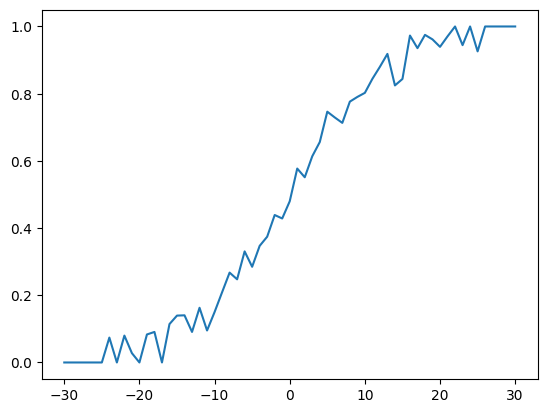

In [57]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

# Plotting predicted point differential against actual win probability

In [58]:
# Fitting a spline model to the above graph

# This is a smoothing and conversion step. It smooths the graph and converts the predicted point differentials into win probabilities
# The win probabilities are used as a proxy for the predicted probability that team 1 wins a given game
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5121283515701943
adjusted logloss of cvsplit 1: 0.5127580106472613
adjusted logloss of cvsplit 2: 0.5109896910539542
adjusted logloss of cvsplit 3: 0.5138242689855739
adjusted logloss of cvsplit 4: 0.5124539452473642
adjusted logloss of cvsplit 5: 0.5154968953162772
adjusted logloss of cvsplit 6: 0.5131440355897819
adjusted logloss of cvsplit 7: 0.5130530132792523
adjusted logloss of cvsplit 8: 0.5124131639588942
adjusted logloss of cvsplit 9: 0.5124452668218439


In [59]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 1.07070352221359
adjusted logloss of cvsplit 1: 1.0715427342852195
adjusted logloss of cvsplit 2: 1.0705185157663784
adjusted logloss of cvsplit 3: 1.0728242050179344
adjusted logloss of cvsplit 4: 1.0727503452014433
adjusted logloss of cvsplit 5: 1.0745656926200775
adjusted logloss of cvsplit 6: 1.0722529670282717
adjusted logloss of cvsplit 7: 1.0719581676742094
adjusted logloss of cvsplit 8: 1.0714039685908405
adjusted logloss of cvsplit 9: 1.0721192139665905


In [60]:
#looking for upsets
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
)

#https://en.wikipedia.org/wiki/NCAA_Division_I_Women%27s_Basketball_Tournament_upsets

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
3290,2018,137,1438,54,1420,74,25.000000,54.181818,7.363636,18.878788,8.393939,13.727273,8.575758,6.787879,14.060606,18.818182,50.151515,6.151515,20.303030,8.393939,8.848485,12.727273,3.878788,2.636364,14.151515,25.612903,58.451613,9.838710,25.774194,9.709677,14.870968,11.677419,7.387097,16.516129,25.322581,56.612903,8.322581,23.161290,9.935484,13.580645,14.322581,6.258065,2.806452,1.516129,1.000000,1.000000,3.627361e+15,-6.192710e+14,1,16,-15
3547,2023,137,1345,58,1192,63,25.441176,55.382353,6.882353,21.088235,11.029412,15.500000,10.411765,4.794118,13.705882,24.058824,57.705882,6.411765,20.411765,6.323529,12.382353,9.088235,6.000000,2.941176,10.352941,27.781250,61.593750,7.843750,22.781250,9.875000,14.312500,11.156250,7.437500,19.125000,26.656250,55.062500,8.156250,22.093750,7.687500,15.031250,14.187500,5.593750,3.875000,0.312500,1.000000,0.666667,6.944138e+14,-2.875661e+15,1,16,-15
2881,2012,137,1181,70,1250,75,25.757576,56.272727,8.121212,21.606061,11.909091,12.454545,12.181818,6.242424,18.181818,25.515152,58.909091,4.454545,14.060606,11.696970,11.151515,12.909091,5.666667,2.666667,9.060606,25.750000,57.812500,7.406250,20.875000,10.843750,13.000000,11.531250,7.812500,17.781250,23.187500,55.562500,5.968750,17.906250,10.218750,13.062500,14.687500,5.687500,3.843750,10.218750,0.500000,1.000000,1.900484e+15,-8.957460e+15,2,15,-13
2884,2012,137,1281,84,1313,86,28.000000,55.588235,8.235294,20.823529,9.176471,16.205882,10.294118,8.205882,14.117647,24.617647,55.794118,6.235294,17.205882,10.764706,12.823529,14.411765,5.264706,2.647059,14.558824,24.312500,54.281250,5.343750,17.031250,11.187500,12.000000,14.812500,6.531250,19.093750,23.375000,57.687500,5.625000,18.468750,12.281250,11.093750,13.656250,6.593750,3.125000,2.812500,1.000000,1.000000,5.543269e+13,-3.547481e+14,2,15,-13
2944,2013,137,1207,68,1195,78,23.000000,50.419355,5.870968,16.419355,9.225806,14.806452,12.677419,7.548387,16.870968,19.419355,51.612903,5.354839,17.580645,10.806452,10.903226,14.225806,6.354839,3.290323,8.838710,26.218750,57.500000,6.625000,20.031250,11.687500,13.718750,14.656250,8.812500,17.593750,23.625000,57.468750,6.875000,21.843750,12.000000,13.281250,15.656250,6.937500,3.031250,5.031250,0.500000,1.000000,6.920308e+14,-2.461859e+14,2,15,-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,2021,138,1325,62,1438,58,29.545455,60.681818,8.590909,23.500000,8.500000,17.636364,11.545455,6.636364,16.272727,25.954545,58.454545,7.863636,23.363636,8.000000,13.681818,14.136364,5.636364,2.409091,7.045455,25.333333,52.750000,8.500000,22.291667,5.541667,13.958333,8.583333,4.916667,12.916667,22.041667,53.000000,6.708333,19.708333,5.875000,11.625000,8.625000,5.125000,2.333333,8.166667,1.000000,1.000000,-6.482156e+15,2.939094e+15,13,4,9
1256,2023,136,1202,68,1438,67,28.000000,58.774194,9.387097,27.290323,8.935484,16.387097,10.612903,6.354839,17.258065,25.838710,57.645161,6.709677,20.258065,8.258065,11.161290,11.870968,5.580645,2.580645,9.000000,24.031250,53.468750,6.812500,19.281250,6.937500,15.812500,8.125000,6.906250,14.312500,21.562500,51.906250,7.000000,20.593750,6.562500,11.406250,11.500000,4.843

In [61]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.49003719687695585
adjusted logloss of cvsplit 1: 0.49047412336756424
adjusted logloss of cvsplit 2: 0.4892302221997852
adjusted logloss of cvsplit 3: 0.49197381862540157
adjusted logloss of cvsplit 4: 0.4904934119702981
adjusted logloss of cvsplit 5: 0.49240632565926257
adjusted logloss of cvsplit 6: 0.4910872447446302
adjusted logloss of cvsplit 7: 0.49099302321230154
adjusted logloss of cvsplit 8: 0.4904643553115599
adjusted logloss of cvsplit 9: 0.4907487898343341


In [62]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.49003719687695585
adjusted logloss of cvsplit 1: 0.49047412336756424
adjusted logloss of cvsplit 2: 0.4892302221997852
adjusted logloss of cvsplit 3: 0.49197381862540157
adjusted logloss of cvsplit 4: 0.4904934119702981
adjusted logloss of cvsplit 5: 0.49240632565926257
adjusted logloss of cvsplit 6: 0.4910872447446302
adjusted logloss of cvsplit 7: 0.49099302321230154
adjusted logloss of cvsplit 8: 0.4904643553115599
adjusted logloss of cvsplit 9: 0.4907487898343341


/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_33302/1651078057.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))


season
2003    0.516119
2004    0.489908
2005    0.493162
2006    0.550707
2007    0.422665
2008    0.458831
2009    0.460737
2010    0.472617
2011    0.484338
2012    0.486586
2013    0.508999
2014    0.489053
2015    0.425124
2016    0.537416
2017    0.470561
2018    0.531554
2019    0.430261
2021    0.528957
2022    0.538185
2023    0.522716
2024    0.464322
dtype: float64

# Submission time!

Note: the below code doesn't work because the sample submission changed from 2023-2024. The rest of this code likely won't be relevant for us. 

In [63]:
"""
sub["Season"] = 2018
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.head()
"""
sub = pd.read_csv(DATA_PATH + "SampleSubmission2023.csv")
sub['Season'] = "2025" #sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
sub.head()


,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2023_1101_1102,0.5,2025,1101,1102
1,2023_1101_1103,0.5,2025,1101,1103
2,2023_1101_1104,0.5,2025,1101,1104
3,2023_1101_1105,0.5,2025,1101,1105
4,2023_1101_1106,0.5,2025,1101,1106


In [64]:
seeds_T1.tail() # should wait on the rest until we have tournament seeds

,Season,T1_TeamID,T1_seed
4229,2024,3435,12
4230,2024,3267,13
4231,2024,3238,14
4232,2024,3263,15
4233,2024,3394,16


In [65]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

sub.head()

ValueError: You are trying to merge on object and int64 columns for key 'Season'. If you wish to proceed you should use pd.concat

In [ ]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [ ]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [10:53:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Fold repeater 1


/Users/blapuma/Documents/GitHub/mmadness-2025/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [10:53:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Fold repeater 2


In [ ]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
"""
sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0
"""
sub[['ID','Pred']].to_csv("submission.csv", index = None)

In [ ]:
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2023_1101_1102,0.213069,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,23.625000,51.125000,8.156250,22.906250,5.625000,15.312500,10.906250,5.750000,17.000000,23.875000,53.687500,5.187500,17.687500,7.937500,10.093750,10.687500,5.718750,3.093750,-0.125000,NaN,NaN,NaN,NaN,0.0,0.0,NaN
1,2023_1101_1103,0.158579,2023,1101,1103,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,25.387097,57.451613,8.806452,25.193548,8.387097,13.000000,10.838710,5.774194,16.193548,24.709677,56.806452,7.064516,20.096774,7.322581,11.483871,11.322581,5.709677,3.032258,5.838710,NaN,NaN,NaN,NaN,0.0,0.5,NaN
2,2023_1101_1104,0.026390,2023,1101,1104,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,27.764706,62.205882,10.058824,29.764706,11.264706,15.205882,13.588235,6.058824,18.617647,23.941176,64.382353,5.529412,19.705882,9.500000,10.000000,11.411765,7.294118,3.705882,13.676471,NaN,6.447588e+14,NaN,1.0,0.0,0.8,NaN
3,2023_1101_1105,0.221231,2023,1101,1105,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,24.233333,56.500000,6.400000,18.466667,8.766667,12.066667,13.733333,7.500000,19.100000,23.600000,55.300000,7.466667,22.066667,9.966667,12.600000,14.166667,7.500000,3.700000,-3.066667,NaN,NaN,NaN,NaN,0.0,0.5,NaN
4,2023_1101_1106,0.258295,2023,1101,1106,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,21.800000,58.566667,5.966667,19.400000,10.300000,9.733333,12.300000,5.666667,17.866667,25.733333,58.800000,6.966667,20.400000,10.633333,11.833333,11.266667,6.733333,4.833333,-10.033333,NaN,NaN,NaN,NaN,0.0,0.0,NaN


In [ ]:
"""
tourney_results2018 = pd.read_csv('../input/NCAA_2018_Solution_Womens.csv')
tourney_results2018 = tourney_results2018[tourney_results2018.Pred!=-1].reset_index(drop=True)
tourney_results2018.columns = ['ID', 'label']
tourney_results2018 = pd.merge(tourney_results2018, sub, on = 'ID')
log_loss(tourney_results2018.label, tourney_results2018.Pred)
"""